In this notebook, I will try to show how the neural network layers give a better represenations of the input data as we go deepper into the network. This notebook is inspired by the [blog](r2rt.com/representational-power-of-deeper-layers.html) 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import trange
import os

In [2]:
sess = tf.InteractiveSession()

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
### It is imprtant the way you initialize the variables
def create_layers(shape, name):
    initial_value = tf.random_normal(shape, stddev=1.0/np.sqrt(shape[0])) 
    return tf.Variable(initial_value, name=name, dtype=tf.float32)

In [5]:
num_itr = 1000
learning_rate = 0.01
batch_size = 1024

In [6]:
input_size = 784
hidden_size_1 = 100
hidden_size_2 = 100
hidden_size_3 = 100
output_size = 10

In [7]:
hidden_1 = create_layers((input_size, hidden_size_1), "hidden_1")
hidden_2 = create_layers((hidden_size_1, hidden_size_2), "hidden_2")
hidden_3 = create_layers((hidden_size_2, hidden_size_3), "hidden_3")
output = create_layers((hidden_size_3, output_size), "output")

In [8]:
input_ = tf.placeholder(tf.float32, shape=(None, 784), name="input")
target = tf.placeholder(tf.float32, shape=(None, 10), name="target")

In [9]:
layer1_output = tf.nn.relu(tf.matmul(input_, hidden_1)) 
layer2_output = tf.nn.relu(tf.matmul(layer1_output, hidden_2)) 
layer3_output = tf.nn.relu(tf.matmul(layer2_output, hidden_3)) 
logit = tf.matmul(layer3_output, output)

In [10]:
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit, target))

In [11]:
# Computing the loss before any training
# It should be around -np.log(0.1) = 2.302
sess.run(tf.initialize_all_variables())
sess.run(cross_entropy_loss, {input_: mnist.train.images, target: mnist.train.labels})

2.3123801

In [12]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

In [13]:
probs = tf.nn.softmax(logit)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(probs, dimension=1), tf.argmax(target, dimension=1)), 
                                  tf.float32))

In [14]:
# Saving the model
saver = tf.train.Saver(max_to_keep=1)

In [15]:
### Bias-Variance Tradeoff in MNIST
def compute_train_test_accuracy():
    train_accuracy = sess.run(accuracy, {input_: mnist.train.images, target: mnist.train.labels})
    test_accuracy = sess.run(accuracy, {input_: mnist.test.images, target: mnist.test.labels})
    return train_accuracy, test_accuracy

In [16]:
saver.restore(sess, "model.ckpt-1")
sess.run(cross_entropy_loss, {input_: mnist.train.images, target: mnist.train.labels})

0.023599308

In [17]:
# sess.run(tf.initialize_all_variables())
# training_losses, testing_losses = [], []
# training_accuracy, testing_accuracy = [], []
# for _ in trange(num_itr):
#     x, y = mnist.train.next_batch(batch_size)
#     _, loss_ = sess.run([train_op, loss], {input_: x, target: y})
#     training_losses.append(loss_)
#     t1, t2 = compute_train_test_accuracy()
#     training_accuracy.append(t1)
#     testing_accuracy.append(t2)
#     if num_itr % 100 == 0:
#         saver.save(sess, os.path.join(os.getcwd(), "model.ckpt"), global_step=1 )
        
    

In [18]:
# # Training losses
# plt.plot(training_losses)

In [19]:
# plt.plot(training_accuracy[-100:], label="Training")
# plt.plot(testing_accuracy[-100:], label="Testing")
# plt.xlabel("Iterations")
# plt.ylabel("Accuracy")
# plt.legend(loc="center")

### Logistic Regression on the output of hidden Layers

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lrs = []
def accuracy(x_train, x_test):
    global lrs
    lrs = []
    lr = LogisticRegression()
    lr.fit(x_train, np.argmax(mnist.train.labels[:1000], 1))
    lrs.append(lr)
    return lr.score(x_test, np.argmax(mnist.test.labels[:1000], 1))

In [22]:
x_trains = [mnist.train.images[:1000]]
x_trains.extend(sess.run([layer1_output, layer2_output, layer3_output], {input_:mnist.train.images[:1000]}))

x_tests = [mnist.test.images[:1000]]
x_tests.extend(sess.run([layer1_output, layer2_output, layer3_output], {input_:mnist.test.images[:1000]}))


In [23]:
for i, (x_train, x_test) in enumerate(zip(x_trains, x_tests)):
    print "the accuracy due to {0}-th hidden layer output is {1}".format(i, accuracy(x_train, x_test))

the accuracy due to 0-th hidden layer output is 0.828
the accuracy due to 1-th hidden layer output is 0.953
the accuracy due to 2-th hidden layer output is 0.976
the accuracy due to 3-th hidden layer output is 0.979


** Conclusion:**

>The ouput of the hidden layers are giving a better representation of the data. However, the transform performance improvement becomes smaller and smaller as we go deeper into the network.

### PCA represenation of the input data

In [24]:
from sklearn.decomposition.pca import PCA

In [25]:
y_train = np.argmax(mnist.train.labels[:1000], 1)

In [26]:
def fit_transform(x_train):
    """
        Apply pca on the x
    """    
    ## pca fit and transform
    pca = PCA(n_components=2)
    x_pca_transform = pca.fit_transform(x_train)
    return x_pca_transform

def plot_pca(x_pca, y):
    ### plotting
    import matplotlib.cm as cm
    plt.figure(figsize = (15, 2.5))
    for start in [0, 3, 6]:
        colors = iter(cm.rainbow(np.linspace(0, 1, 4)))
        plt.subplot(1, 3, start / 3 + 1)        
        for i in range(start, start + 4):
            x_digit = x_pca[y == i]
            plt.scatter(x_digit[:, 0], x_digit[:, 1], color=next(colors), label=str(i))
        plt.legend()

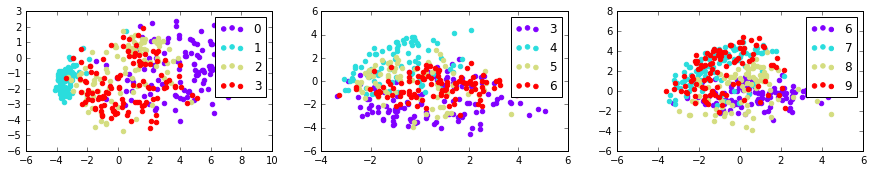

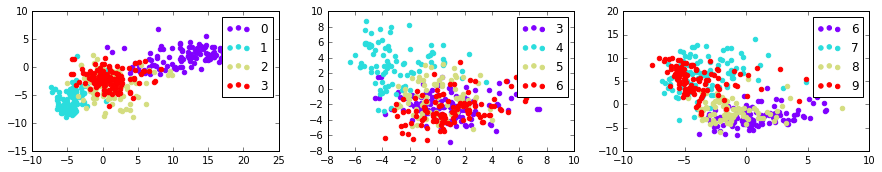

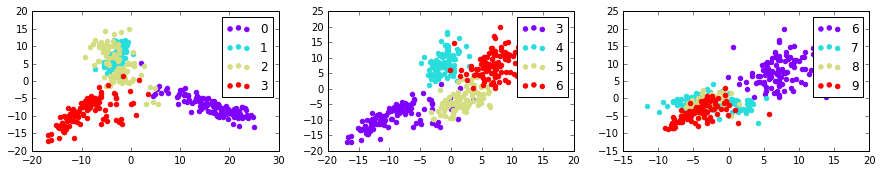

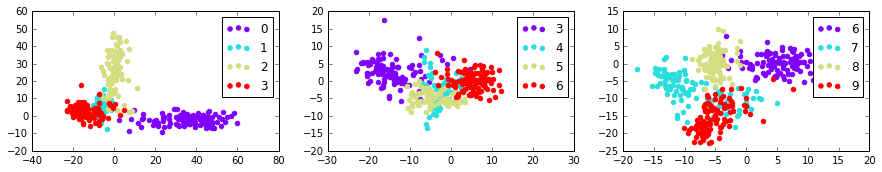

In [27]:
for x_train in x_trains:
    x_pca = fit_transform(x_train)
    plot_pca(x_pca, y_train)

### Learning from the learning

We would like to see if we can use the previous learning to enhance the learning capabilities of Neural Network. For this experiment, we will also train the neural network to predict the the first three principle components of the final hidden layer.

In [28]:
# number of principal component
pca_components = 3

In [29]:
# Fitting PCA
pca = PCA(n_components=pca_components)
x_pca_train = layer3_output.eval({input_:mnist.train.images})
pca.fit(x_pca_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
# Creating place-holders and variables for PCA
pca_output = tf.placeholder(tf.float32, shape=(None, pca_components), name="pca_output") 
pca_layer_1 = create_layers((input_size, pca_components), "pca")

In [32]:
# Training and testing output
pca_train = tf.matmul(input_, pca_layer_1)
pca_loss = tf.reduce_mean(tf.squared_difference(pca_output, pca_train))

In [33]:
pca_plus_cross_entropy_loss = cross_entropy_loss + pca_loss

In [34]:
train_op_for_combined_loss = tf.train.AdamOptimizer(learning_rate).minimize(pca_plus_cross_entropy_loss)

In [ ]:
pca_train.eval({input_: })

In [38]:
#tf.reset_default_graph()
sess.run(tf.initialize_all_variables())
training_losses, testing_losses = [], []
training_accuracy, testing_accuracy = [], []
for i in trange(num_itr):
    x, y = mnist.train.next_batch(batch_size)
    x_pca = pca.transform(x)
    _, loss_ = sess.run([train_op_for_combined_loss, pca_plus_cross_entropy_loss], 
                        {input_: x, target: y, pca_output: x_pca})
    training_losses.append(loss_)
    t1, t2 = compute_train_test_accuracy()
    training_accuracy.append(t1)
    testing_accuracy.append(t2)
    if num_itr % 100 == 0:
        saver.save(sess, os.path.join(os.getcwd(), "model.ckpt"), global_step=1 )

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (1024,784) (100,) 

In [41]:
mnist.train.images.shape

(55000, 784)

In [42]:
num_itr

1000